## Основной код



In [91]:
!pip install yfinance
!pip install gdeltdoc

In [117]:
import yfinance as yf
import pandas as pd
from gdeltdoc import Filters, GdeltDoc
import re


def get_data_yfinance(quotation: str, start_date: str, end_date: str, interval='1d') -> pd.DataFrame:
    """Взять данные с yahoo finance
    params:
      quotation: название котировки, данные для которой хотим получить
      start_date, end_date - интервал, формат "год-месяц-день"
      interval - периодичность, формат "(номер)(первая буква слова (d, m, y))"
    returns:
      DataFrame формата "Тикет, Время, 6 видов цен"
    """
    df_res = yf.download(tickers=quotation,
                         start=start_date,
                         end=end_date,
                         interval=interval)
    df_res.loc[:, 'Ticker'] = quotation
    df_res = df_res.groupby(pd.Grouper(level="Date", freq=interval.upper())).mean()
    # Приводим время к одному виду для слияния
    df_res.index = pd.to_datetime(df_res.index).tz_localize('Etc/UCT')
    return df_res


def get_data_gdelt(quotation: str, keywords: list, start_date: str, end_date: str, interval="1d", num_records=250,
                   repeats=3) -> pd.DataFrame:
    """Взять данные с gdelt
    params:
      quotation - имя ценной бумаги
      keywords - из графа знаний по ключевому слову
      start_date, end_date - интервал, формат "год-месяц-день"
      (опционально) interval - периодичность, формат "(номер)(первая буква слова (d, m, y))"
      (не реализована) (опционально) num_records - сколько максимум записей взять за промежуток
      (не реализовано) (опционально) repeats - сколько раз должно повториться ключевое слово в статье
    returns:
      DataFrame формата "Datetime (индекс), Ticker,
        [Average_Tone, Article_Count, Volume_Intensity]_[std, mean, sum, min, max]
    """

    df_res = None
    df_dub = pd.DataFrame()
    # Как называются колонки в полученных DataFrames
    col_names = ['Average_Tone', 'Article_Count', 'Volume_Intensity']

    # Что будем искать для данных ключевых слов
    # Тон статей, их количество и их кол-во в отношении ко всем остальным
    match_list = ["timelinetone", "timelinevolraw", "timelinevol"]
    match_dict = dict(zip(match_list, col_names))
    for ft in keywords:
        f = Filters(
            start_date=start_date,
            end_date=end_date,
            # num_records=num_records,
            keyword=ft
        )

        gd = GdeltDoc()
        # Get a timeline of the number of articles matching the filters
        for timeline in match_list:
            timeline_data = gd.timeline_search(timeline, f)
            timeline_data = timeline_data.fillna(0)
            timeline_data = timeline_data.groupby(pd.Grouper(key="datetime", freq=interval.upper()))

            if timeline in ['timelinetone']:
                timeline_data = timeline_data.mean()
            else:
                timeline_data = timeline_data.sum()

            # Собираем все фичи в один датафрейм, далее их разделим
            col_name = match_dict[timeline]
            df_dub[f"{ft}_{timeline}_{col_name}"] = timeline_data[col_name.replace('_', ' ')].values

            # Так как мы копируем только колонки, то надо один раз откопировать дату в итог
            if df_res is None:
                # Так же выровняем индексы, чтобы при копировании не выдавалось NaN
                df_res = pd.DataFrame(index=timeline_data.index)
                df_dub.index = timeline_data.index

    # Нужно создать колонки со средним, средним отклонением, минимумом и максимумом для каждой фичи
    # Для начала нужно найти все колонки, для которых будем это считать
    columns = df_dub.columns

    # Сначала сформируем список датафреймов, которые нам нужно достать для каждой колонки
    for pattern in col_names:
        pattern_list = list()
        for col in columns:
            if pattern in col:
                pattern_list.append(col)

        # Теперь для pattern у нас есть список
        # Посчитаем для неё std, mean, min, max, sum
        df_res[f'{pattern}_min'] = df_dub[pattern_list].min(axis=1, skipna=True)
        df_res[f'{pattern}_max'] = df_dub[pattern_list].max(axis=1, skipna=True)
        df_res[f'{pattern}_mean'] = df_dub[pattern_list].mean(axis=1, skipna=True)
        df_res[f'{pattern}_std'] = df_dub[pattern_list].std(axis=1, skipna=True)
        df_res[f'{pattern}_sum'] = df_dub[pattern_list].sum(axis=1, skipna=True)

    df_res.loc[:, 'Ticker'] = quotation
    return df_res


def get_dataframe(**kwargs) -> pd.DataFrame:
    """ Получить полный датафрейм с источников
        Пример использования: d = get_dataframe(quotation='NVDA', 
                                                keywords=['nvidia'], 
                                                start_date="2020-01-01", 
                                                end_date="2020-12-31")
        params:
          quotation - имя ценной бумаги
          keywords - из графа знаний по ключевому слову
          start_date, end_date - интервал, формат "год-месяц-день"
          (опционально) interval - периодичность, формат "(номер)(первая буква слова (d, m, y))"
          (не реализована) (опционально) num_records - сколько максимум записей взять за промежуток
          (не реализовано) (опционально) repeats - сколько раз должно повториться ключевое слово в статье
        returns:
          DataFrame формата "Datetime (индекс), Ticker,
            [Average_Tone, Article_Count, Volume_Intensity]_[std, mean, sum, min, max], - из новостей
            Open, High, Low, Close, Adj Close, Volume - из финансов
    """

    gdelt_data = get_data_gdelt(**kwargs)
    yfinance_data = get_data_yfinance(quotation=kwargs['quotation'],
                                      start_date=kwargs['start_date'],
                                      end_date=kwargs['end_date'],
                                      interval="1d" if not kwargs.get('interval') else kwargs['interval'])
    res = pd.concat([gdelt_data, yfinance_data], axis=1)
    del gdelt_data
    del yfinance_data
    return res

In [120]:
features = [
    'nvidia', 'geforce', 'geforce rtx', 'geForce now', 'nvidia rtx', 'nvidia shield', 'nvidia dgx'
]
d = get_dataframe(quotation='NVDA', keywords=features, start_date="2017-01-01", end_date="2020-12-31")

[*********************100%***********************]  1 of 1 completed


In [94]:
def get_structure_clickhouse(d: pd.DataFrame) -> list:
  """
    Получить структуру DataFrame в виде кортежей (колонка, Тип)
    Пример результата: ('Average_Tone_min', 'Float64')
  """
  s = list()
  for c in d.columns:
    s.append((c, str(d.dtypes[c]).capitalize()))
  return s

In [95]:
def get_data_clickhouse(d: pd.DataFrame) -> dict:
  """
    Получает данные в нужном виде для импорта в ClickHouse
  """
  return d.to_dict(orient='list')

In [96]:
d

,Average_Tone_min,Average_Tone_max,Average_Tone_mean,Average_Tone_std,Average_Tone_sum,Article_Count_min,Article_Count_max,Article_Count_mean,Article_Count_std,Article_Count_sum,Volume_Intensity_min,Volume_Intensity_max,Volume_Intensity_mean,Volume_Intensity_std,Volume_Intensity_sum,Ticker,Open,High,Low,Close,Adj Close,Volume
2017-01-01 00:00:00+00:00,-0.9807,2.2388,0.366143,1.059744,2.5630,0,137,24.428571,50.927586,171,0.0,0.0320,0.005700,0.011895,0.0399,NVDA,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02 00:00:00+00:00,0.0000,2.4007,0.805600,0.889093,5.6392,0,227,43.428571,85.035007,304,0.0,0.0383,0.007343,0.014341,0.0514,NVDA,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03 00:00:00+00:00,0.0000,1.4433,0.510957,0.661593,3.5767,0,965,178.142857,361.165442,1247,0.0,0.1273,0.023514,0.047642,0.1646,NVDA,104.400002,106.370003,99.379997,102.010002,100.770882,37549900.0
2017-01-04 00:00:00+00:00,0.0000,1.6605,0.650771,0.694668,4.5554,0,788,164.285714,302.387563,1150,0.0,0.0958,0.019971,0.036753,0.1398,NVDA,103.400002,105.500000,101.529999,104.389999,103.121964,29980500.0
2017-01-05 00:00:00+00:00,0.0000,2.2410,1.079014,0.818871,7.5531,0,1726,427.000000,620.806196,2989,0.0,0.2079,0.051429,0.074782,0.3600,NVDA,104.529999,105.820000,101.050003,101.739998,100.504166,24607400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27 00:00:00+00:00,0.0000,0.8600,0.319300,0.366063,2.2351,0,60,15.000000,21.863211,105,0.0,0.0275,0.006871,0.010018,0.0481,NVDA,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28 00:00:00+00:00,-0.0689,3.7037,1.196857,1.304839,8.3780,0,126,34.142857,45.105168,239,0.0,0.0371,0.010071,0.013276,0.0705,NVDA,522.500000,522.500000,510.529999,516.000000,516.000000,5314100.0
2020-12-29 00:00:00+00:00,0.0000,2.0161,0.965429,0.732552,6.7580,0,196,45.428571,70.672619,318,0.0,0.0531,0.012300,0.019152,0.0861,NVDA,517.000000,522.900024,513.690002,517.729980,517.729980,4259300.0
2020-12-30 00:00:00+00:00,-1.0357,0.4726,0.089586,0.534822,0.6271,0,169,37.285714,60.780244,261,0.0,0.0457,0.010071,0.016438,0.0705,NVDA,519.609985,528.549988,515.869995,525.830017,525.830017,5634900.0


## Проценты и изменение переменной + бонус

In [122]:
def get_shift_digit(s: pd.Series) -> pd.Series:
  """
    Возвращает колонку с изменениями значений 
    Для вызова этой функции необходимо очистить колонки Close от NaN
  """
  assert not s.isna().any(), "Необходимо очистить колонку от NaN"
  return (s.shift(-1) - s).shift(1) 

In [123]:
def get_shift_percentage(numerator: pd.Series, denominator: pd.Series) -> pd.Series:
  """
    На сколько процентов изменилась переменная numerator 
    относительно текущего denominator 
  """
  return numerator / denominator * 100

In [124]:
s = d['Close'].dropna()
d['Price_Change'] = get_shift_feature(s)

In [125]:
d[['Close', 'Price_Change']]

,Close,Price_Change
2017-01-01 00:00:00+00:00,NaN,NaN
2017-01-02 00:00:00+00:00,NaN,NaN
2017-01-03 00:00:00+00:00,102.010002,NaN
2017-01-04 00:00:00+00:00,104.389999,2.379997
2017-01-05 00:00:00+00:00,101.739998,-2.650002
...,...,...
2020-12-27 00:00:00+00:00,NaN,NaN
2020-12-28 00:00:00+00:00,516.000000,-3.750000
2020-12-29 00:00:00+00:00,517.729980,1.729980
2020-12-30 00:00:00+00:00,525.830017,8.100037


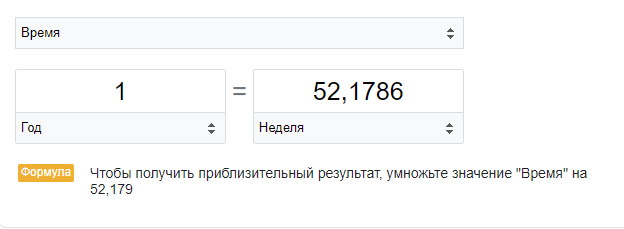

52 * 2 = 104 -> 
115 - 104 = 11 праздничных дней у биржи :(

In [126]:
d['Price_Change'].isna().sum()

456

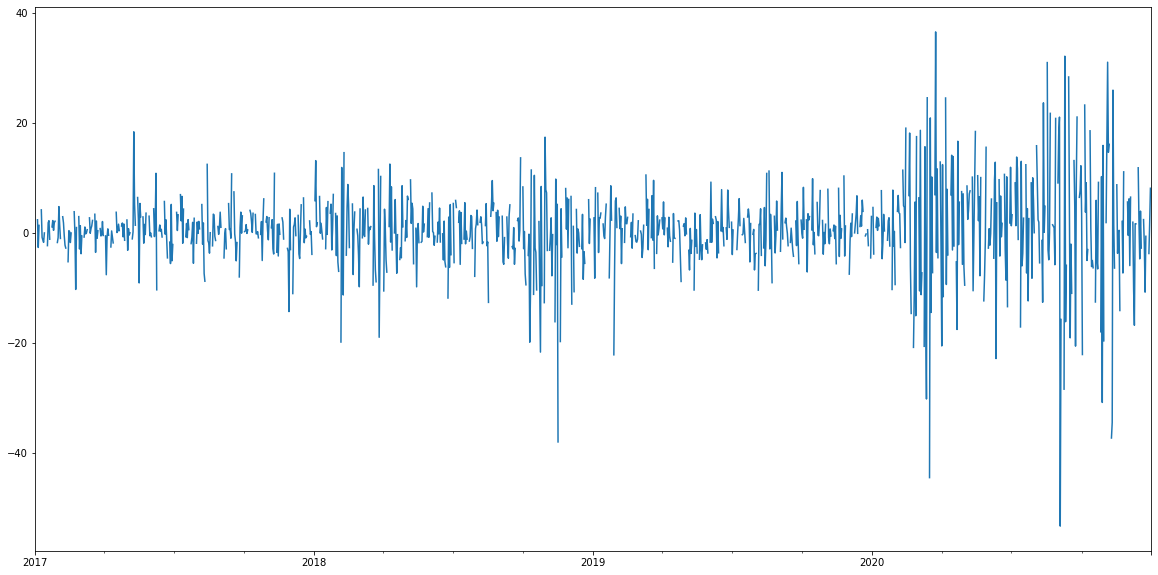

In [127]:
d['Price_Change'].plot(figsize=(20, 10))

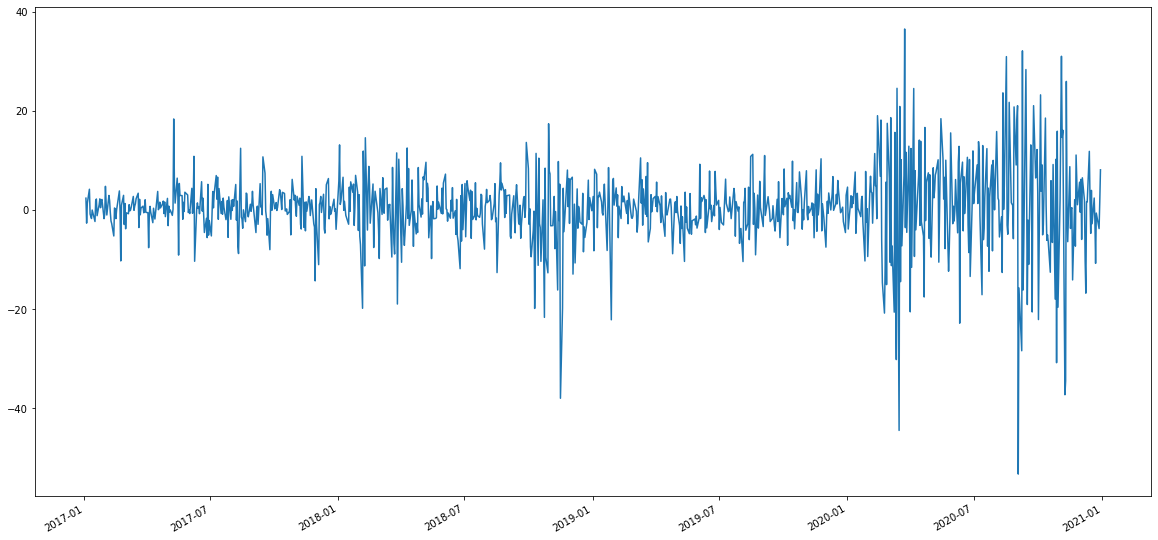

In [128]:
d['Price_Change'].dropna().plot(figsize=(20, 10))

In [129]:
d['Percentage_Change'] = get_shift_percentage(d['Price_Change'], d['Close'])

In [130]:
d[['Close', 'Price_Change', 'Percentage_Change']]

,Close,Price_Change,Percentage_Change
2017-01-01 00:00:00+00:00,NaN,NaN,NaN
2017-01-02 00:00:00+00:00,NaN,NaN,NaN
2017-01-03 00:00:00+00:00,102.010002,NaN,NaN
2017-01-04 00:00:00+00:00,104.389999,2.379997,2.279909
2017-01-05 00:00:00+00:00,101.739998,-2.650002,-2.604680
...,...,...,...
2020-12-27 00:00:00+00:00,NaN,NaN,NaN
2020-12-28 00:00:00+00:00,516.000000,-3.750000,-0.726744
2020-12-29 00:00:00+00:00,517.729980,1.729980,0.334147
2020-12-30 00:00:00+00:00,525.830017,8.100037,1.540429


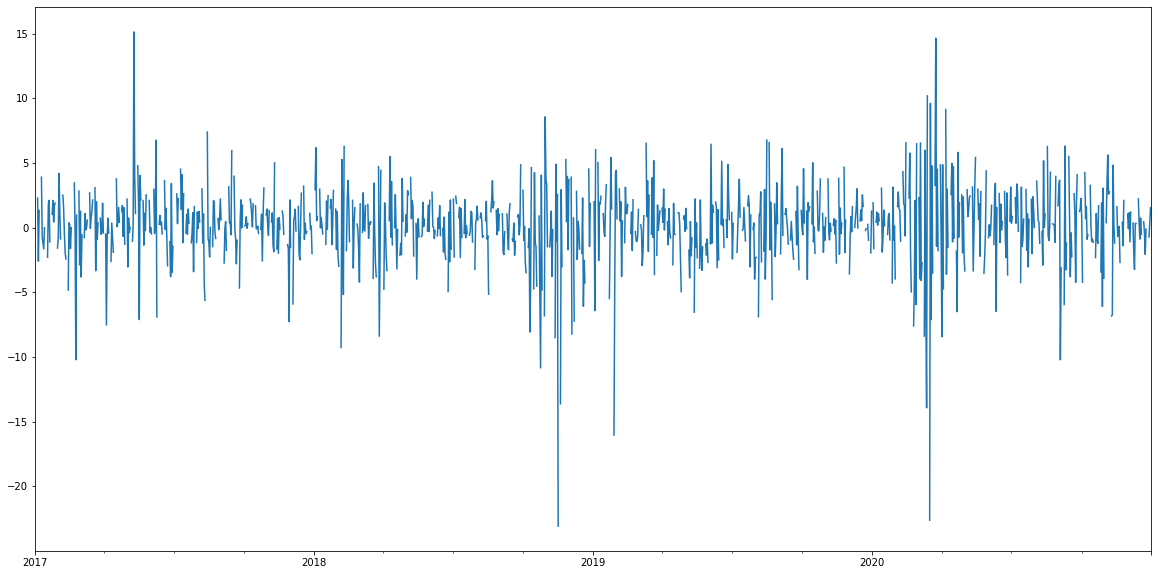

In [131]:
d['Percentage_Change'].plot(figsize=(20, 10))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


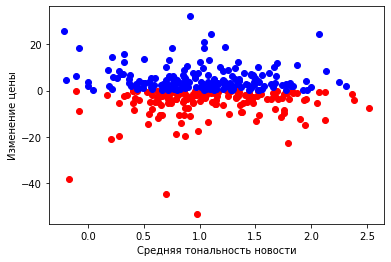

In [132]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.xlabel('Средняя тональность новости')
plt.ylabel('Изменение цены')
plt.scatter(d.iloc[::3][d['Price_Change'] < 0]['Average_Tone_mean'], 
            d.iloc[::3][d['Price_Change'] < 0]['Price_Change'], 
            color='red')
plt.scatter(d.iloc[::3][d['Price_Change'] >= 0]['Average_Tone_mean'], 
            d.iloc[::3][d['Price_Change'] >= 0]['Price_Change'], 
            color='blue')
plt.show()

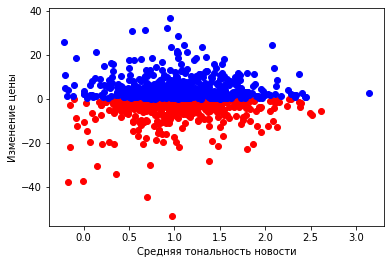

In [133]:
plt.xlabel('Средняя тональность новости')
plt.ylabel('Изменение цены')
plt.scatter(d[d['Price_Change'] < 0]['Average_Tone_mean'], 
            d[d['Price_Change'] < 0]['Price_Change'], 
            color='red')
plt.scatter(d[d['Price_Change'] >= 0]['Average_Tone_mean'], 
            d[d['Price_Change'] >= 0]['Price_Change'], 
            color='blue')
plt.show()

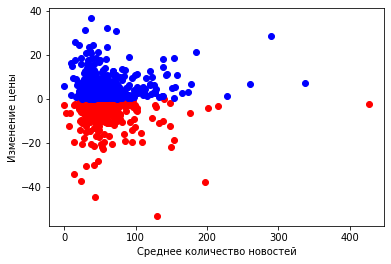

In [134]:
plt.xlabel('Среднее количество новостей')
plt.ylabel('Изменение цены')
plt.scatter(d[d['Price_Change'] < 0]['Article_Count_mean'], 
            d[d['Price_Change'] < 0]['Price_Change'], 
            color='red')
plt.scatter(d[d['Price_Change'] >= 0]['Article_Count_mean'], 
            d[d['Price_Change'] >= 0]['Price_Change'], 
            color='blue')
plt.show()

**Хоть какая-то зацепка...**
*Гипотеза:* В большинстве случаев, если начинается хайп, то цена растет.

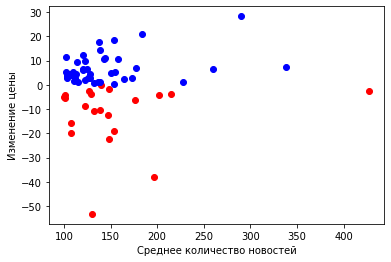

In [135]:
plt.xlabel('Среднее количество новостей')
plt.ylabel('Изменение цены')
plt.scatter(d[(d['Price_Change'] < 0) & (d['Article_Count_mean'] > 100)]['Article_Count_mean'], 
            d[(d['Price_Change'] < 0) & (d['Article_Count_mean'] > 100)]['Price_Change'], 
            color='red')
plt.scatter(d[(d['Price_Change'] >= 0) & (d['Article_Count_mean'] > 100)]['Article_Count_mean'], 
            d[(d['Price_Change'] >= 0) & (d['Article_Count_mean'] > 100)]['Price_Change'], 
            color='blue')
plt.show()

In [136]:
# Когда цена растет
d[(d['Price_Change'] >= 0) & (d['Article_Count_mean'] > 100)].dropna().count().mean()

44.0

In [137]:
# Когда цена падает
d[(d['Price_Change'] < 0) & (d['Article_Count_mean'] > 100)].dropna().count().mean()

21.0

## Цель: взять больше, чем 1500 записей

In [ ]:
def get_more_gdelt_data(quotation: str, keywords: list, start_date: str, 
                        end_date: str, interval="1d", num_records=250,
                        repeats=3) -> pd.DataFrame:
  """
    Взять больше, чем 1500 записей
  """
  